In [579]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing.imputation import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
# from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os
import random
import matplotlib.pyplot as plt

In [580]:
def makeUserTarget(df, user):
    aux = []
    for _, row in df.iterrows():
        if row.our_data == 0:
            if(np.floor(row.SessionID/100).astype(int) == user):
                aux.append(1)
            else:
                aux.append(0)
        else:
            if 'Diego' in row.SessionID and user == 'Diego':
                aux.append(1)
            elif 'Toto' in row.SessionID and user == 'Toto':
                aux.append(1)
            elif (('Jo' in row.SessionID) or ('jo' in row.SessionID)) and user == 'Jo':
                aux.append(1)
            else:
                aux.append(0)
    df['target'] = aux

In [581]:
def separateIntoTrainAndTest(df, test_sessions = [],randomn = 10):
    targetSessionIds = list(df[df.target == 1].SessionID.unique())
    targetChoosenSession = random.choice(targetSessionIds)
    notTargetSessionIds = list(df[df.target == 0].SessionID.unique())
    notTargetChoosenSessions = test_sessions
    for i in range(randomn):
        notTargetChoosenSession = random.choice(notTargetSessionIds) 
        notTargetChoosenSessions.append(notTargetChoosenSession)
        notTargetSessionIds.remove(notTargetChoosenSession)
    df_train = df[(df.SessionID != targetChoosenSession) & (~df.SessionID.isin(notTargetChoosenSessions))]
    df_test = df[(df.SessionID == targetChoosenSession) | (df.SessionID.isin(notTargetChoosenSessions))]
    
    return df_train, df_test

In [582]:
def getOurDataUsers(row):
    if 'Diego' in row.SessionID :
        return('Diego')
    elif 'Toto' in row.SessionID:
        return('Toto')
    elif ('Jo' in row.SessionID) or ('jo' in row.SessionID):
        return('Jo')

In [583]:
#file_name = 'aggregated_features'
file_name = '10secs_aggregated_features'
our_data_file_name = 'our_data_aggregated_features'
to_drop = []
df = pd.read_csv('./' + file_name + '.csv')
our_data_df = pd.read_csv('./' + our_data_file_name + '.csv')
df['our_data'] = 0
our_data_df['our_data'] = 1

In [584]:
users = (np.floor(df.SessionID/100).astype(int)).unique()
our_data_users = our_data_df.apply(getOurDataUsers,axis=1)

In [585]:
df = df.append(our_data_df,ignore_index=True)

In [586]:
#df = df[df.our_data != 0]

In [587]:
sessionsToDrop = ['Diego01']

In [588]:
df = df[~df.SessionID.isin(sessionsToDrop)]

In [589]:
#user = random.choice(users)
user = 'Toto'
makeUserTarget(df, user)

In [590]:
#to_drop =  ['our_data','Contact_size_mean','Contact_size_std'] 
#to_drop =  ['our_data','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std']
to_drop =  ['our_data','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std','Contact_size_mean','Pressure_mean','Pressure_std','Contact_size_std']
#to_drop =  ['our_data','Mag_Z_mean','Mag_X_mean','Mag_Y_mean','Mag_Y_std','Mag_Z_std','Mag_X_std','Pressure_mean','Pressure_std']

In [591]:
df_train, df_test = separateIntoTrainAndTest(df,test_sessions=['oscar1','Pedro1','Carlos1','Andres1'],randomn=1)

In [592]:
df_train = df_train.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)
df_test = df_test.set_index(["SessionID", 'WindowNumber']).drop(to_drop, axis=1)

In [593]:
x_train, y_train = df_train.drop("target", axis=1), df_train["target"]

In [594]:
y_train.to_frame('target').groupby('target').size()[1]

225

In [595]:
negative_positive = y_train.to_frame('target').groupby('target').size()
sum_negative = negative_positive[0]
sum_positive = negative_positive[1]
scale_pos_weight = sum_negative/sum_positive

In [596]:
clf = xgb.XGBClassifier(n_estimators=90, max_depth=9, random_state=31, colsample_bytree=0.6, colsample_bylevel=0.5, learning_rate=0.11, subsample=0.9, scale_pos_weight=scale_pos_weight)
clf2 = xgb.XGBClassifier(n_estimators=90, max_depth=9, random_state=31, colsample_bytree=0.6, colsample_bylevel=0.5, learning_rate=0.11, subsample=0.9)
#clf = RandomForestClassifier()

In [597]:
clf.fit(x_train, y_train)
clf2.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.6, gamma=0, learning_rate=0.11, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=90,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=31, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.9)

In [598]:
x_test, y_test = df_test.drop("target", axis=1), df_test["target"]

In [599]:
predict = clf.predict_proba(x_test)
predict2 = clf2.predict_proba(x_test)
predict

array([[9.99957383e-01, 4.26011720e-05],
       [9.99953032e-01, 4.69938241e-05],
       [9.99920368e-01, 7.96155218e-05],
       [9.99943078e-01, 5.69362455e-05],
       [9.99951601e-01, 4.84268567e-05],
       [9.99870300e-01, 1.29675464e-04],
       [9.99948204e-01, 5.17752524e-05],
       [9.99951780e-01, 4.82014584e-05],
       [9.99938250e-01, 6.17546903e-05],
       [9.99948144e-01, 5.18836459e-05],
       [9.99949157e-01, 5.08570847e-05],
       [9.99957383e-01, 4.26011720e-05],
       [9.99947011e-01, 5.30112957e-05],
       [9.99917448e-01, 8.25633470e-05],
       [9.99937296e-01, 6.27050540e-05],
       [9.99948323e-01, 5.16533946e-05],
       [9.99951839e-01, 4.81358693e-05],
       [9.99956727e-01, 4.32570341e-05],
       [9.99956846e-01, 4.31260960e-05],
       [9.99960482e-01, 3.95274583e-05],
       [9.99945939e-01, 5.40400943e-05],
       [9.99946177e-01, 5.38229033e-05],
       [9.99960482e-01, 3.95274583e-05],
       [9.99957383e-01, 4.26011720e-05],
       [9.999498

In [600]:
clf.predict(x_test)
clf2.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [601]:
df_predict = pd.DataFrame(clf.predict_proba(x_test)[:, 1], columns=["prob"], index=x_test.index)
df_predict2 = pd.DataFrame(clf2.predict_proba(x_test)[:, 1], columns=["prob"], index=x_test.index)

In [602]:
df_socorro = df_predict.merge(df_test[['target']], right_index=True, left_index=True)
df_socorro2 = df_predict2.merge(df_test[['target']], right_index=True, left_index=True)

In [603]:
df_socorro[df_socorro.target == 0].reset_index().groupby('SessionID').mean()


,WindowNumber,prob,target
SessionID,,,
78589919,29.071429,0.000054,0
Andres1,28.466667,0.616787,0
Carlos1,37.265306,0.164513,0
Pedro1,37.061538,0.370926,0
oscar1,6.928571,0.164003,0


In [604]:
df_socorro2[df_socorro2.target == 0].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
78589919,29.071429,0.000050,0
Andres1,28.466667,0.447130,0
Carlos1,37.265306,0.072853,0
Pedro1,37.061538,0.268080,0
oscar1,6.928571,0.166176,0


In [605]:
df_socorro[df_socorro.target == 1].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
Toto7,13.0,0.737062,1


In [606]:
df_socorro2[df_socorro2.target == 1].reset_index().groupby('SessionID').mean()

,WindowNumber,prob,target
SessionID,,,
Toto7,13.0,0.320256,1


<Figure size 432x288 with 0 Axes>

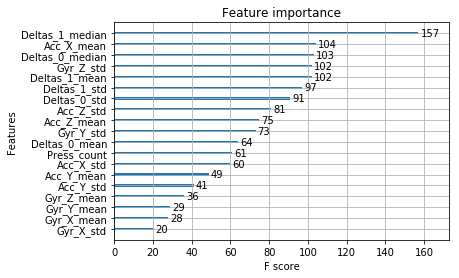

<Figure size 432x288 with 0 Axes>

In [607]:
xgb.plot_importance(clf)
plt.figure()

In [608]:
i_pred_proba = clf.predict_proba(x_test)
auc = roc_auc_score(y_test, i_pred_proba[:, 1])
auc

0.8266213812065341

In [609]:
i_pred_proba2 = clf2.predict_proba(x_test)
auc2 = roc_auc_score(y_test, i_pred_proba2[:, 1])
auc2

0.7100113213650332